This notebook illustrates a simple price forecasting tool using the `miso` module.

In [1]:
import os, sys
sys.path.append(os.getcwd().replace("/docs","/source"))
import miso

Load the price data and convert to column-wise data by load node.

In [2]:
lmp = miso.Node("2021-01-01","2021-12-31","rt_lmp_final",values="LMP",types="Loadzone")
price = lmp.dataframe().reset_index().pivot("Datetime","Node","Value")

Load the quantity data, drop the total load data, and convert to column-wise data by load resource zone.

In [3]:
dfal = miso.Zone("2021-01-01","2021-12-31","df_al",types="Actual",values="LOAD")
quantity = dfal.dataframe().reset_index().pivot("Datetime","Zone","Value")

In [4]:
data = price.dropna(axis=1)
nodes = data.columns
data = data.join(quantity.drop("MISO",axis=1).dropna(axis=1))
zones = data.columns[-(len(data.columns)-len(nodes)):]
forecast = ["OTP.MDU"]

In [33]:
N = 1#len(nodes) # nodes to use
Z = 1#len(zones) # zones to use
K = 1 # model order
H = 750 # hold out data for testing
T = data.index.to_list() # time index
P = data.iloc[:,0:N].values # node price values
Q = data.iloc[:,-Z:].values # zone quantity values

In [34]:
from numpy import hstack
from numpy.linalg import solve
L = len(T)
M = hstack([hstack([P[n:L-K+n-H-1] for n in range(K+1)]),
            hstack([Q[n:L-K+n-H-1] for n in range(K+1)])])
Mt = M.transpose()
x = solve(Mt@M,Mt@P[K+1:L-H])

In [35]:
import pandas
pandas.DataFrame(M)

,0,1,2,3
0,18.61,19.60,16457.38,15949.78
1,19.60,19.57,15949.78,15635.68
2,19.57,19.50,15635.68,15400.35
3,19.50,19.53,15400.35,15517.66
4,19.53,19.44,15517.66,15583.79
...,...,...,...,...
8003,57.41,85.02,19340.49,18692.74
8004,85.02,49.75,18692.74,18131.09
8005,49.75,52.63,18131.09,18022.08
8006,52.63,49.49,18022.08,17856.19


Mean absolute error = 19 $/MWh


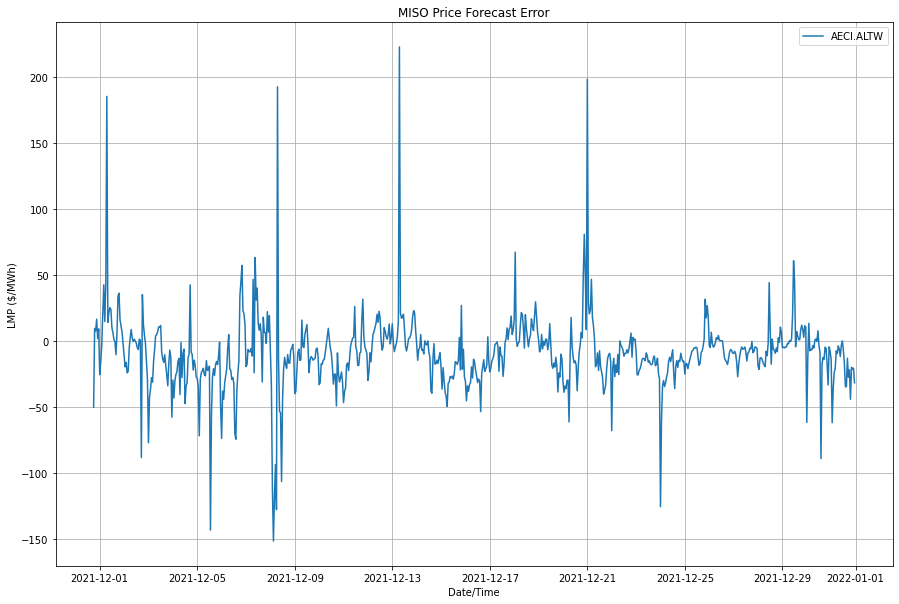

In [31]:
Pp = M[-H:]@x
from matplotlib.pyplot import *
figure(figsize=(15,10))
plot(T[-H:],P[-H:]-Pp)
grid()
title("MISO Price Forecast Error")
xlabel("Date/Time")
ylabel("LMP ($/MWh)")
legend(nodes[:N])
print(f"Mean absolute error = {(sum(abs(Pp-P[-H:]))/H)[0]:.2g} $/MWh")